In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/kaggle dataset'

!kaggle datasets download -d username/dataset name

In [ ]:
!kaggle datasets download -d prondeau/the-car-connection-picture-dataset

the-car-connection-picture-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

100% 1.82G/1.82G [00:17<00:00, 123MB/s]
100% 1.82G/1.82G [00:17<00:00, 113MB/s]


In [ ]:
!unzip '/content/the-car-connection-picture-dataset.zip' -d '/content/drive/MyDrive/car/bigData'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/car/bigData/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_Fel.jpg  
  inflating: /content/drive/MyDrive/car/bigData/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_GON.jpg  
  inflating: /content/drive/MyDrive/car/bigData/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_JXa.jpg  
  inflating: /content/drive/MyDrive/car/bigData/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_LNH.jpg  
  inflating: /content/drive/MyDrive/car/bigData/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_LhY.jpg  
  inflating: /content/drive/MyDrive/car/bigData/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_LlQ.jpg  
  inflating: /content/drive/MyDrive/car/bigData/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_MOs.jpg  
  inflating: /content/drive/MyDrive/car/bigData/Toyota_Sequoia_2019_60_20_380_57_8_79_77_205_13_4WD_8_4_SUV_MTX.jpg  
  inf

In [ ]:
!unzip '/content/stanford-cars-dataset.zip' -d '/content/drive/MyDrive/car/'

Archive:  /content/stanford-cars-dataset.zip
replace /content/drive/MyDrive/car/cars_annos.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/drive/MyDrive/car/cars_test/cars_test/00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
img_dir='/content/drive/MyDrive/car/' 

In [ ]:
import os
big_data=os.listdir(img_dir+'/bigData')
car_train=os.listdir(img_dir+'cars_train/cars_train')
car_test=os.listdir(img_dir+'/cars_test/cars_test')

In [ ]:
print(len(big_data))
print(len(car_train))
print(len(car_test))

64467
8144
8041


In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from google.colab import files
import numpy as np

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
params={
        'bsize':64, #batch size
        'imsize':64, #image size
        'nc':3, #number of channels
        'nz':128, #latent
        'ngf':64, #number of generator feature
        'ndf':64, #number of discriminator feature
        'nepochs':10, #number of epoch
        'lr':0.0002, #learning rate
        'save_epoch':2 #save models
    }
imgNormalization = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
def utili(stats,params,img_dir):
    transformers=transforms.Compose([transforms.Resize(params['imsize']),transforms.CenterCrop(params['imsize']),transforms.ToTensor(),transforms.Normalize(*stats)])
    data=torchvision.datasets.ImageFolder(root=img_dir,transform=transformers)
    train_dl=torch.utils.data.DataLoader(data,batch_size=params['bsize'],shuffle=True)
    return train_dl

train_dl=utili(imgNormalization,params,img_dir)

In [ ]:
print(train_dl.dataset)

Dataset ImageFolder
    Number of datapoints: 80652
    Root location: /content/drive/MyDrive/car/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


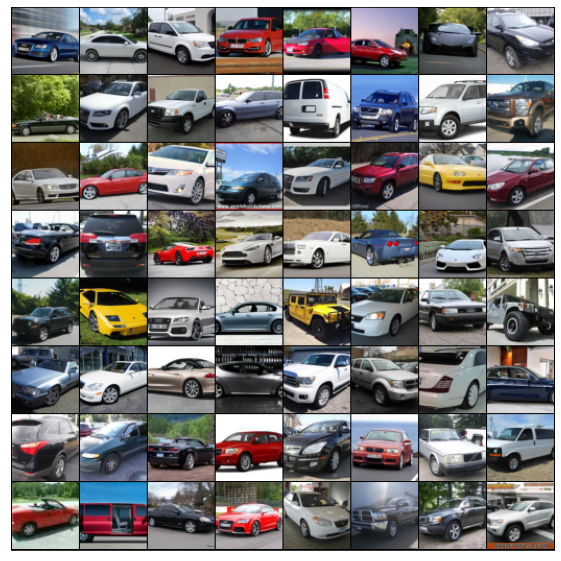

In [ ]:
for real_img,_ in train_dl:
  break
fig,ax=plt.subplots(figsize=(10,10))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(np.transpose(torchvision.utils.make_grid(real_img, padding=1, normalize=True), (1,2,0)))

In [ ]:
def discriminator(params):
  discriminator=nn.Sequential(
      nn.Conv2d(in_channels=params['nc'],
                out_channels=params['ngf'],
                kernel_size=4,
                stride=2,
                padding=2,
                bias=False),
      nn.BatchNorm2d(params['ndf']),
      nn.LeakyReLU(0.2,inplace=True),


      nn.Conv2d(params['ndf'],params['ndf']*2,4,2,1,bias=False),
      nn.BatchNorm2d(params['ndf']*2),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(params['ndf']*2,params['ndf']*4,4,2,1,bias=False),
      nn.BatchNorm2d(params['ndf']*4),
      nn.LeakyReLU(0.2,inplace=True),
                            
      nn.Conv2d(params['ndf']*4,params['ndf']*8,4,2,1,bias=False),
      nn.BatchNorm2d(params['ndf']*8),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(params['ndf']*8,1,kernel_size=4,stride=1,padding=0,bias=False),
      nn.Flatten(),
      nn.Sigmoid()
      
  )
  return discriminator

In [ ]:
def generator(params):
  generator=nn.Sequential(
    nn.ConvTranspose2d(in_channels=params['nz'],
                               out_channels=params['ngf']*8,
                               kernel_size=4,
                               stride=2,
                              padding=0,bias=False),
                    nn.BatchNorm2d(params['ngf']*8),
            nn.ReLU(True),


            nn.ConvTranspose2d(in_channels=params['ngf']*8,
                               out_channels=params['ngf']*4,
                               kernel_size=4,
                               stride=2,
                               padding=1,bias=False),
                        nn.BatchNorm2d(params['ngf']*4),
                        nn.ReLU(True),
                             
             nn.ConvTranspose2d(in_channels=params['ngf']*4,
                                out_channels=params['ngf']*2,
                                kernel_size=4,stride=2,padding=1,bias=False),
                          nn.BatchNorm2d(params['ngf']*2),
                          nn.ReLU(True),
                          
              nn.ConvTranspose2d(in_channels=params['ndf']*2,
                                 out_channels=params['ndf'],
                                 kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(params['ngf']),
              nn.ReLU(True),

            nn.ConvTranspose2d(params['ngf'],params['nc'],4,2,1,bias=False),
            nn.Tanh()
  )
  return generator

In [ ]:
discriminator=discriminator(params)
generator=generator(params)

In [ ]:
def train_discriminator(real_img,opt_d,params,epoch):
    opt_d.zero_grad()

    real_preds=discriminator(real_img)
    real_target=torch.ones(real_img.size(0),1)
    real_loss=F.binary_cross_entropy(real_preds,real_target)
    real_score=torch.mean(real_preds).item()

    latent=torch.randn(params['bsize'],params['nz'],1,1)
    fake_img=generator(latent)

    fake_target=torch.zeros(fake_img.size(0),1)
    fake_preds=discriminator(fake_img)
    fake_loss=F.binary_cross_entropy(fake_preds,fake_target)
    fake_score=torch.mean(fake_preds).item()

    d_loss=real_loss+fake_loss
    d_loss.backward()
    opt_d.step()
    return real_score,fake_score,d_loss.item()

In [ ]:
def train_generator(params,opt_g,epoch,train_dl):
  opt_g.zero_grad()

  latent=torch.randn(params['bsize'],params['nz'],1,1)
  fake_img=generator(latent)

  fake_label=torch.ones(params['bsize'],1)
  preds=discriminator(fake_img)
  g_loss=F.binary_cross_entropy(preds,fake_label)

  g_loss.backward(retain_graph=True)
  opt_g.step()
  
  return g_loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir='generated_img'
os.makedirs(sample_dir,exist_ok=True)

In [ ]:
def save_samples(index,fixed_latent,show=True):
  fake_img=generator(fixed_latent)
  fake_fname='generated-images-{0:0=4d}.png'.format(index)
  save_image(fake_img,os.path.join(sample_dir,fake_fname),nrow=8)

In [ ]:
fixed_latent=torch.randn(params['bsize'],params['nz'],1,1)
save_samples(0,fixed_latent)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
def fit(params,start_idx=1):
  count=0
  lossess_g=[]
  lossess_d=[]
  real_scores=[]
  fake_scores=[]
 
  loss_f_g=0
  loss_f_d=0

  opt_g=torch.optim.Adam(generator.parameters(),lr=params['lr'],betas=(0.5, 0.999))
  opt_d=torch.optim.Adam(discriminator.parameters(),lr=params['lr'],betas=(0.5, 0.999))
 
  for epoch in range(params['nepochs']):
    print(count)
    save_samples(params['nepochs']+start_idx,fixed_latent,show=True)
 
    for real_img,_ in tqdm(train_dl):
      count+=1
      loss_d,real_score,fake_score=train_discriminator(real_img,opt_d,params,epoch)
      loss_g=train_generator(params,opt_g,epoch,train_dl)
      
    lossess_g.append(loss_g)
    lossess_d.append(loss_d)
      
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}],learning_rate {:.4f},loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, params['nepochs'],params['lr'], loss_g, loss_d, real_score, fake_score))
    
  return lossess_g,lossess_d,real_scores,fake_scores

In [ ]:
history=fit(params)

In [ ]:
torch.save(generator.state_dict(),'G.ckpt')
torch.save(discriminator.state_dict(),'D.ckpt')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
import numpy as np

with torch.no_grad():
    fake_img=generator(xb)
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake_img, padding=2, normalize=True), (1,2,0)))
    plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
generatorss = torch.load('G.ckpt')
generator.load_state_dict(generatorss)

<All keys matched successfully>

In [ ]:
import numpy as np
with torch.no_grad():
    fake_img=generator(xb)
    fig,ax=plt.subplots(figsize=(10,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(np.transpose(torchvision.utils.make_grid(fake_img, padding=1, normalize=True), (1,2,0)))